In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import datetime
import math

%matplotlib inline
%reload_ext tensorboard

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

def create_split(df, pct_train, pct_val, batch_size, window_size):
    length = df.shape[0]
    temp_train_size = find_batch_gcd(math.floor(pct_train * length), batch_size)
    test_size = length - temp_train_size
    train_size = find_batch_gcd(math.floor((1 - pct_val) * temp_train_size), batch_size)
    val_size = temp_train_size - train_size
    df_train = df[:- val_size - test_size]
    df_val = df[- val_size - test_size - window_size:- test_size]
    df_test = df[- test_size - window_size:]
    return df_train, df_val, df_test

def find_batch_gcd(length, batch_size):
    while length % batch_size != 0:
        length -= 1
    return length

def create_dataset(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size])
    return np.array(X), np.array(y)

def create_multi_pred_dataset(df, window_size, time_steps):
    X, y = [], []
    for i in range(len(df) - window_size - time_steps - 1):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size:i + window_size + time_steps].values)
    return np.array(X), np.array(y)

def create_model(nodes, optimizer, dropout, X_train):
    model = Sequential()
    model.add(LSTM(nodes[0], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(nodes[1], return_sequences=True))
    model.add(LSTM(nodes[2]))
    model.add(Dropout(dropout))
    model.add(Dense(nodes[3]))
    model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
    return model

def train_model(pair, batch_size, window_size, time, nodes_arr, optimizer, dropout, epochs):
    series = pd.read_csv("../data/processed/{}_processed.csv".format(pair))
    
    series = series[series.shape[0] % batch_size:]
    close = series[['Real Close']]
    series = series.drop(['Time', 'Real Close'], axis=1)
    series = series[['Close', 'EMA_10', 'EMA_50', 'RSI', 'A/D Index',
                     'AUD Interest Rate', 'CAD Interest Rate', 'AUD_CPI', 'CAD_CPI',
                     'AUD Twitter Sentiment', 'CAD Twitter Sentiment', 'AUD News Sentiment', 'CAD News Sentiment',
                     #'EUR_GDP', 'USD_GDP', 'EUR_PPI', 'USD_PPI', 'USD Unemployment Rate', 'EUR Unemployment Rate'
                    ]]

    df_train, df_val, df_test = create_split(series, 0.75, 0.1, batch_size, window_size)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_val.shape}, df_test.shape {df_test.shape}')
    
    closeScaler = MinMaxScaler(feature_range=(0, 1))
    featureScaler = MinMaxScaler(feature_range=(0, 1))
    df_train = df_train.copy()
    df_val = df_val.copy()
    #df_test = df_test.copy()
    df_train.loc[:, ['Close']] = closeScaler.fit_transform(df_train[['Close']])
    df_train.loc[:, ~df_train.columns.isin(['Close'])] = featureScaler.fit_transform(df_train.loc[:, ~df_train.columns.isin(['Close'])])
    df_val.loc[:, ['Close']] = closeScaler.transform(df_val[['Close']])
    df_val.loc[:, ~df_val.columns.isin(['Close'])] = featureScaler.transform(df_val.loc[:, ~df_val.columns.isin(['Close'])])
    #df_test.loc[:, ['Close']] = closeScaler.transform(df_test[['Close']])
    #df_test.loc[:, ~df_test.columns.isin(['Close'])] = featureScaler.transform(df_test.loc[:, ~df_test.columns.isin(['Close'])])

    #X_train, y_train = create_dataset(df_train, window_size)
    #X_val, y_val = create_dataset(df_val, window_size)
    #X_test, y_test = create_dataset(df_test, window_size)
    
    X_train, y_train = create_multi_pred_dataset(df_train, window_size, nodes_arr[3])
    X_val, y_val = create_multi_pred_dataset(df_val, window_size, nodes_arr[3])
    #X_test, y_test = create_multi_pred_dataset(df_test, window_size, nodes_arr[3])

    model = create_model(nodes_arr, optimizer, dropout, X_train)
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = "logs/training/" + current_time
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch', profile_batch=0, histogram_freq=1)

    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[tensorboard_callback]
                   )
    model.save("../models/{}".format(pair))
    joblib.dump(featureScaler, "../scalers/{}/features.bin".format(pair))
    joblib.dump(closeScaler, "../scalers/{}/close.bin".format(pair))
    
    del model
    
    return history

def visualize_loss(history):
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.subplots(1)
    ax1.set_title('Model Loss')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.legend()

In [3]:
batch_size = 32
window_size = 96
nodes = [80, 64, 32, 480]
time = 15
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
dropout = 0.2
epochs = 10
history = train_model("AUDCAD", batch_size, window_size, time, nodes, optimizer, dropout, epochs)

df_train.shape (50400, 13), df_validation.shape (5696, 13), df_test.shape (18784, 13)
Epoch 1/10
1557/1557 [==============================] - 191s 123ms/step - loss: 0.0092 - mae: 0.0598 - val_loss: 8.4829e-04 - val_mae: 0.0159
Epoch 2/10
1557/1557 [==============================] - 180s 115ms/step - loss: 0.0017 - mae: 0.0318 - val_loss: 8.5939e-04 - val_mae: 0.0163
Epoch 3/10
1557/1557 [==============================] - 180s 116ms/step - loss: 9.1408e-04 - mae: 0.0225 - val_loss: 8.1503e-04 - val_mae: 0.0145
Epoch 4/10
1557/1557 [==============================] - 181s 116ms/step - loss: 4.6719e-04 - mae: 0.0147 - val_loss: 8.1544e-04 - val_mae: 0.0145
Epoch 5/10
1557/1557 [==============================] - 184s 118ms/step - loss: 2.7827e-04 - mae: 0.0095 - val_loss: 8.1504e-04 - val_mae: 0.0145
Epoch 6/10
1557/1557 [==============================] - 185s 119ms/step - loss: 2.3966e-04 - mae: 0.0079 - val_loss: 8.1494e-04 - val_mae: 0.0144
Epoch 7/10
1557/1557 [========================

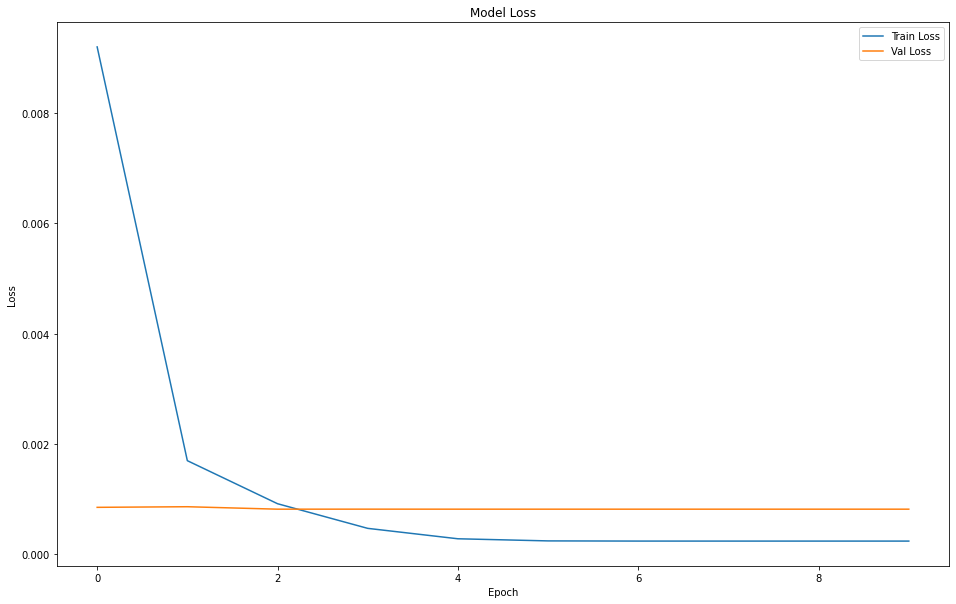

In [4]:
visualize_loss(history)

In [5]:
tensorboard --logdir logs/training

Reusing TensorBoard on port 6006 (pid 18896), started 4 days, 14:52:34 ago. (Use '!kill 18896' to kill it.)